# Machine Learning Avanzato per la Bank Fraud Detection

Il rilevamento delle frodi creditizie è un problema di classificazione binaria in cui l'obiettivo è identificare transazioni fraudolente all'interno di un flusso massiccio di dati legittimi.

### Le Sfide Tecniche:
1. **Imbalanced Data**: In un dataset reale, le frodi rappresentano spesso meno dello 0,5% del totale. Usare l'accuratezza standard porterebbe a modelli inutili.
2. **Costi Asimmetrici**: Un falso negativo (non rilevare una frode) costa molto più di un falso positivo (bloccare una carta legittima).
3. **Adattabilità**: I frodatori cambiano tattica costantemente.

In questo studio utilizzeremo il dataset **Credit Card Fraud Detection** (PCA-transformed) scaricandolo direttamente online.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE

# Setting grafico
plt.style.use('ggplot')
pd.options.display.max_columns = None

## 1. Acquisizione dei Dati

Scarichiamo il dataset da un repository pubblico. Questo dataset contiene transazioni effettuate da titolari di carte di credito europee nel settembre 2013.
Le feature da `V1` a `V28` sono il risultato di una trasformazione **PCA** (Principal Component Analysis) per motivi di privacy. Le uniche feature non trasformate sono `Time` e `Amount`.

In [4]:
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

print(f"Dimensioni del dataset: {df.shape}")
df.head()

Dimensioni del dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Exploratory Data Analysis (EDA) Profonda

Analizziamo la distribuzione della variabile target `Class` (0 = Legittima, 1 = Frode).

Distribuzione Classi:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


/var/folders/v8/28w_x9996x5dy7_1sx65rg3h0000gn/T/ipykernel_95402/1261199738.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


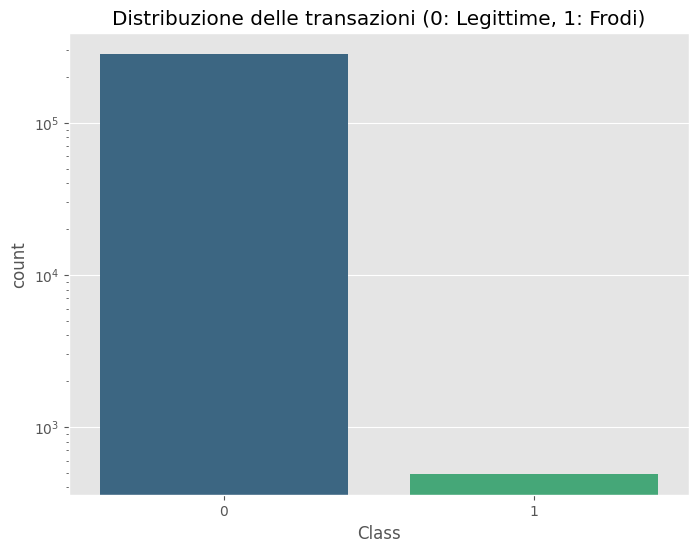

In [5]:
print("Distribuzione Classi:")
print(df['Class'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Distribuzione delle transazioni (0: Legittime, 1: Frodi)')
plt.yscale('log') # Usiamo scala logaritmica per vedere la classe minoritaria
plt.show()

### Analisi dell'importo della transazione
C'è una differenza statistica tra l'importo delle frodi e quello delle transazioni normali?

In [6]:
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

print("Statistiche Importi Frodi:")
print(fraud['Amount'].describe())
print("\nStatistiche Importi Normali:")
print(normal['Amount'].describe())

Statistiche Importi Frodi:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Statistiche Importi Normali:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


## 3. Preprocessing e Feature Scaling

Le variabili `Time` e `Amount` hanno scale molto diverse dalle componenti PCA. Utilizzeremo un **RobustScaler**, che è meno sensibile agli outlier (molto comuni nei dati finanziari) rispetto allo StandardScaler standard.

In [7]:
rs = RobustScaler()

df['scaled_amount'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rs.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Spostiamo le colonne scalate all'inizio
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 4. Gestione dello Sbilanciamento: Teoria di SMOTE

Addestrare un modello su dati così sbilanciati porterebbe a un modello pigro che dice sempre "0". 

**SMOTE (Synthetic Minority Over-sampling Technique)** crea nuovi esempi sintetici della classe minoritaria invece di duplicare quelli esistenti. Lo fa selezionando esempi vicini nello spazio delle feature e creando punti lungo la linea che li unisce.



In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

# Splitting PRIMA di applicare SMOTE per evitare data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Originale train set: {np.bincount(y_train)}")
print(f"Resampled train set: {np.bincount(y_train_res)}")

Originale train set: [227451    394]
Resampled train set: [227451 227451]


## 5. Modellazione: Random Forest 

Utilizzeremo due approcci:
1. **Supervisionato (Random Forest)**: Apprende la distinzione tra le due classi.

In [9]:
# Modello 1: Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_probs_rf = rf.predict_proba(X_test)[:, 1]

## 6. Valutazione Avanzata: Precision-Recall Curve

In frode bancaria, l'accuratezza è inutile. Ci interessano:
* **Recall**: Quale percentuale di frodi abbiamo catturato?
* **Precision**: Quando diciamo "frode", quanto spesso abbiamo ragione?

La **Precision-Recall Curve** è molto più informativa della curva ROC quando le classi sono sbilanciate.

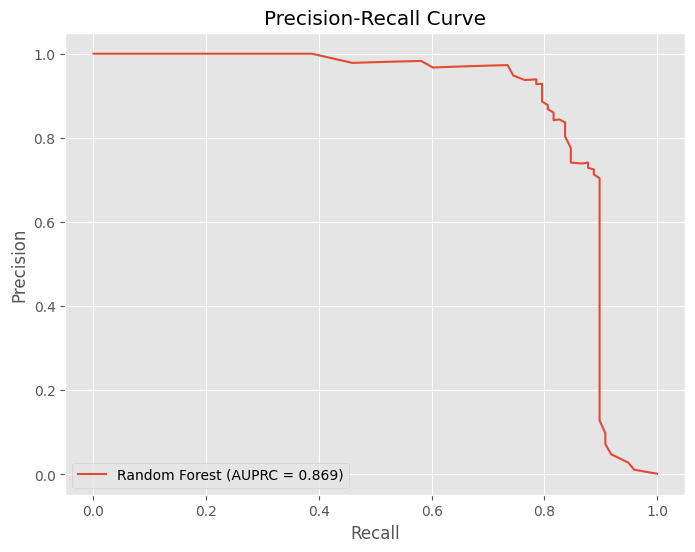

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rf)
auprc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AUPRC = {auprc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

## 7. Anomaly Detection con Isolation Forest

L'Isolation Forest "isola" le osservazioni partizionando ricorsivamente i dati. Poiché le frodi sono poche e diverse, richiedono meno partizioni per essere isolate rispetto ai punti normali.



Confusion Matrix Isolation Forest:


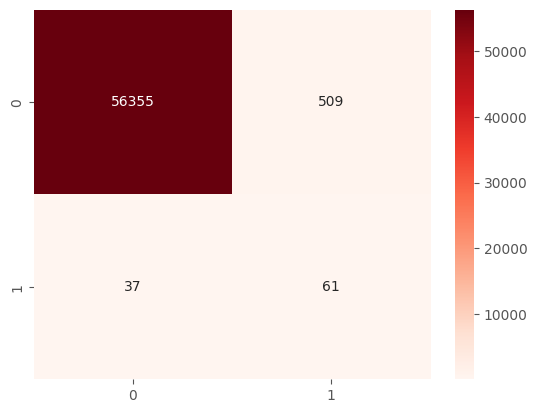

In [11]:
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
y_pred_iso = iso_forest.fit_predict(X_test)

# Convertiamo l'output (-1 per anomalia, 1 per normale) in formato (1 per frode, 0 per normale)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

print("Confusion Matrix Isolation Forest:")
sns.heatmap(confusion_matrix(y_test, y_pred_iso), annot=True, fmt='d', cmap='Reds')
plt.show()

## 8. Conclusioni e Strategia Bancaria

L'analisi ha dimostrato che:
1. **Random Forest con SMOTE** offre una Precision eccellente, minimizzando i disagi ai clienti legittimi.
2. **Isolation Forest** è utile per scoprire nuovi tipi di frode che il modello supervisionato non ha mai visto.

**Suggerimento operativo**: Una banca dovrebbe implementare un sistema a due livelli: un modello rapido (tipo LogReg) per il filtraggio iniziale e un ensemble complesso (Random Forest/XGBoost) per le transazioni sospette ad alto valore.